In [1]:
import numpy as np 
import pandas as pd 

import os
import torch
import torchvision
from PIL import Image
import os.path
import torch.optim as optim
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import torch.optim as optim

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
traincsvPath = "/content/drive/MyDrive/Thermal Imaging/Readings_training.csv"
testcsvPath = "/content/drive/MyDrive/Thermal Imaging/Readings_testing.csv"
valcsvPath = "/content/drive/MyDrive/Thermal Imaging/Readings_validation.csv"
dataPath = "/content/drive/MyDrive/Thermal Imaging/DATASET/Filtered/"
bestModelPath = "/content/drive/MyDrive/Thermal Imaging/bestModel.pth"

In [5]:
traindf = pd.read_csv(traincsvPath)
testdf = pd.read_csv(testcsvPath)
valdf = pd.read_csv(valcsvPath)

# Create a list of train, test and val images, SBP and DBP

In [6]:
trainLabels = []
testLabels = []
valLabels = []

trainSBP = []
testSBP = []
valSBP = []

trainDBP = []
testDBP = []
valDBP = []

In [7]:
for index, row in traindf.iterrows():
  if os.path.isfile(dataPath + row['Image'])  is False:
    continue
  trainLabels.append(dataPath + row['Image'])
  trainSBP.append(row['SBP'])
  trainDBP.append(row['DBP'])

for index, row in testdf.iterrows():
  if os.path.isfile(dataPath + row['Image'])  is False:
    continue
  testLabels.append(dataPath + row['Image'])
  testSBP.append(row['SBP'])
  testDBP.append(row['DBP'])

for index, row in valdf.iterrows():
  if os.path.isfile(dataPath + row['Image'])  is False:
    continue
  valLabels.append(dataPath + row['Image'])
  valSBP.append(row['SBP'])
  valDBP.append(row['DBP'])

# Apply Image transformation, extract features and create dataloader class

## Image Transformation and feature extraction model

In [8]:
# Image Transformations as expected by resnet101 as input
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
denseNet201 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
denseNet201

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [10]:
layers = list(denseNet201.children())[:-1]
denseNetModel = torch.nn.Sequential(*layers)
denseNetModel.to('cpu')
denseNetModel.eval()
denseNetModel

Sequential(
  (0): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): R

In [11]:
trainImgs, testImgs, valImgs = [], [], []

# Transform and load image vectors in trainImgs, testImgs, valImgs
for img in trainLabels:
  image = Image.open(os.path.join(dataPath, img))
  image = preprocess(image).unsqueeze(0)
  feature = denseNetModel(image).detach().numpy()
  trainImgs.append(feature)

for img in testLabels:
  image = Image.open(os.path.join(dataPath, img))
  image = preprocess(image).unsqueeze(0)
  feature = denseNetModel(image).detach().numpy()
  testImgs.append(feature)

for img in valLabels:
  image = Image.open(os.path.join(dataPath, img))
  image = preprocess(image).unsqueeze(0)
  feature = denseNetModel(image).detach().numpy()
  valImgs.append(feature)

In [12]:
# Dataset class 
class thermalDataset(Dataset):
  def __init__(self, features, sbp, dbp):
      super().__init__()
      self.features = features
      self.sbp = sbp 
      self.dbp = dbp

  def __len__(self):
    return len(self.features)

  def __getitem__(self, indx):
    self.sbp[indx] = np.float32(self.sbp[indx] / 180.00)
    self.dbp[indx] = np.float32(self.dbp[indx] / 180.00)
    return {'feature': self.features[indx], 'sbp': self.sbp[indx], 'dbp': self.dbp[indx]}

In [13]:
train_dataset = thermalDataset(trainImgs, trainSBP, trainDBP)
test_dataset = thermalDataset(testImgs, testSBP, testDBP)
val_dataset = thermalDataset(valImgs, testSBP, testDBP)

train_data_loader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle = True, num_workers = 1)
test_data_loader = DataLoader(dataset = test_dataset, batch_size = 16, shuffle = True, num_workers = 1)
val_data_loader = DataLoader(dataset = val_dataset, batch_size = 16, shuffle = True, num_workers = 1)

# Model Implementation (DenseNet Feature Layers + Dense Layers)

In [14]:
# Removed classification layers, used pretrained alexnet for feature extraction, added own fcc layers.
class modifiedpreTrainedDenseNet201_1(torch.nn.Module):
  def __init__(self):
    super(modifiedpreTrainedDenseNet201_1, self).__init__()
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(94080, 8192, bias=True)

    self.fcsbp1 = torch.nn.Linear(8192, 4096, bias=True) #FOR SBP
    self.fcsbp2 = torch.nn.Linear(4096, 2048, bias=True)
    self.fcsbpout = torch.nn.Linear(2048, 1, bias=True) # SBP output

    self.fcdbp1 = torch.nn.Linear(8192, 4096, bias=True) #For DBP
    self.fcdbp2 = torch.nn.Linear(4096, 2048, bias=True) 
    self.fcdbpout = torch.nn.Linear(2048, 1, bias=True) #DBP output

  def forward(self, features):
    features = self.flatten(features)
    features = F.relu(self.fc1(features)) #First FCC Layer

    sbp = F.relu(self.fcsbp1(features))     #SBP output
    sbp = F.relu(self.fcsbp2(sbp))
    sbp = F.relu(self.fcsbpout(sbp))

    dbp = F.relu(self.fcdbp1(features))     #DBP output
    dbp = F.relu(self.fcdbp2(dbp))
    dbp = F.relu(self.fcdbpout(dbp))

    return {'sbp': sbp, 'dbp': dbp}

    

# Number of trainable parameters

In [15]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [16]:
count_parameters(modifiedpreTrainedDenseNet201_1())

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
|    fc1.weight   | 770703360  |
|     fc1.bias    |    8192    |
|  fcsbp1.weight  |  33554432  |
|   fcsbp1.bias   |    4096    |
|  fcsbp2.weight  |  8388608   |
|   fcsbp2.bias   |    2048    |
| fcsbpout.weight |    2048    |
|  fcsbpout.bias  |     1      |
|  fcdbp1.weight  |  33554432  |
|   fcdbp1.bias   |    4096    |
|  fcdbp2.weight  |  8388608   |
|   fcdbp2.bias   |    2048    |
| fcdbpout.weight |    2048    |
|  fcdbpout.bias  |     1      |
+-----------------+------------+
Total Trainable Params: 854614018


854614018

# Training the model

In [17]:
num_epochs = 101
steps_per_epoch = len(trainImgs)
model = modifiedpreTrainedDenseNet201_1()
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = torch.nn.MSELoss()
maeLoss = torch.nn.L1Loss()

In [18]:
trainSBPLoss = []
trainDBPLoss = []
valSBPLoss = []
valDBPLoss = []

trainSBPMAE = []
trainDBPMAE = []
valSBPMAE = []
valDBPMAE = []

globalMinLoss = 10000
bestEpoch = -1

for epoch in range(num_epochs):
  trainloss = 0.0
  valLoss = 0.0

  trainsbpLoss = 0.0
  traindbpLoss = 0.0
  valsbpLoss = 0.0
  valdbpLoss = 0.0

  trainsbpmae = 0.0
  traindbpmae = 0.0
  valsbpmae = 0.0
  valdbpmae = 0.0

  model.train()

  for batch_idx, sample in enumerate(train_data_loader):
    feature, sbp, dbp = sample['feature'].to(device), sample['sbp'].to(device), sample['dbp'].to(device)
    optimizer.zero_grad()
    output = model(feature)
    sbp = sbp.unsqueeze(1)
    dbp = dbp.unsqueeze(1)
    
    sbpLoss = criterion(output['sbp'], sbp)
    dbpLoss = criterion(output['dbp'], dbp) 

    sbpmae = maeLoss(output['sbp'], sbp)
    dbpmae = maeLoss(output['dbp'], dbp)  

    loss = sbpLoss + dbpLoss
    trainsbpmae += sbpmae.item()
    traindbpmae += dbpmae.item()
    trainloss += loss.item()
    trainsbpLoss += sbpLoss.item()
    traindbpLoss += dbpLoss.item()

    loss.backward()
    optimizer.step() 

  # trainLoss.append(trainloss/len(trainImgs))
  trainSBPMAE.append(trainsbpmae/len(trainImgs))
  trainDBPMAE.append(traindbpmae/len(trainImgs))
  trainSBPLoss.append(trainsbpLoss/len(trainImgs))
  trainDBPLoss.append(traindbpLoss/len(trainImgs))

  # print("Epoch: ", epoch, "  TrainLoss: ", trainloss, "TrainSBPLoss: ", trainsbpLoss, "TrainDBPLoss: ", traindbpLoss)

  with torch.no_grad():
    model.eval()
    for batch_idx, sample in enumerate(val_data_loader):
      feature, sbp, dbp = sample['feature'].to(device), sample['sbp'].to(device), sample['dbp'].to(device)
      output = model(feature)
      sbp = sbp.unsqueeze(1)
      dbp = dbp.unsqueeze(1)

      sbpLoss = criterion(output['sbp'], sbp)
      dbpLoss = criterion(output['dbp'], dbp)    
      loss = sbpLoss + dbpLoss
      sbpmae = maeLoss(output['sbp'], sbp)
      dbpmae = maeLoss(output['dbp'], dbp)

      valLoss += loss.item()
      valsbpmae += sbpmae.item()
      valdbpmae += dbpmae.item()
      valsbpLoss += sbpLoss.item()
      valdbpLoss += dbpLoss.item()
    
    if(valLoss < globalMinLoss):
      torch.save(model, bestModelPath)
      globalMinLoss = valLoss
      bestEpoch = epoch

  # validationLoss.append(valLoss/len(valImgs))
  valSBPLoss.append(valsbpLoss/len(valImgs))
  valDBPLoss.append(valdbpLoss/len(valImgs))  
  valSBPMAE.append(valsbpmae/len(valImgs))
  valDBPMAE.append(valdbpmae/len(valImgs))

  print("Epoch: ", epoch, "  TrainLoss: ", trainloss, "ValLoss: ", valLoss)
print("Best model obtained at epoch: ", bestEpoch)

Epoch:  0   TrainLoss:  2.306875690817833 ValLoss:  0.4766886681318283
Epoch:  1   TrainLoss:  1.432829961180687 ValLoss:  0.3037048876285553
Epoch:  2   TrainLoss:  0.4716941239312291 ValLoss:  0.01643626019358635
Epoch:  3   TrainLoss:  0.19452261365950108 ValLoss:  0.009355413960292935
Epoch:  4   TrainLoss:  0.07928694525617175 ValLoss:  0.01039318391121924
Epoch:  5   TrainLoss:  0.030077136121690273 ValLoss:  0.008473854046314955
Epoch:  6   TrainLoss:  0.018197738434537314 ValLoss:  0.00535808433778584
Epoch:  7   TrainLoss:  0.011175825726240873 ValLoss:  0.004065276239998639
Epoch:  8   TrainLoss:  0.006171653236378916 ValLoss:  0.003133030899334699
Epoch:  9   TrainLoss:  0.004262700356775895 ValLoss:  0.003218131430912763
Epoch:  10   TrainLoss:  0.0028364699392113835 ValLoss:  0.002928218338638544
Epoch:  11   TrainLoss:  0.002077826575259678 ValLoss:  0.003028669918421656
Epoch:  12   TrainLoss:  0.001509960049588699 ValLoss:  0.0024472808581776917
Epoch:  13   TrainLoss: 

In [19]:
print("Best Epoch:", bestEpoch)

Best Epoch: 36


In [20]:
def plotLosses(trainSBP, trainDBP, valSBP, valDBP, trainSBPMAE, trainDBPMAE, valSBPMAE, valDBPMAE):
  plt.figure(figsize=(10,10))
  plt.subplot(2,2,1)
  plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
  plt.plot(trainDBPMAE)
  plt.plot(valDBPMAE)
  plt.xlabel("Epoch")
  plt.ylabel("Mean Absolute Error")
  plt.title("(a) Model MAE (DBP Level)")
  plt.legend(['Train', 'Validation'])
  plt.grid(linestyle = '--', linewidth = 0.5)

  plt.subplot(2,2,2)
  plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
  plt.plot(trainSBPMAE)
  plt.plot(valSBPMAE)
  plt.xlabel("Epoch")
  plt.ylabel("Mean Absolute Error")
  plt.title("(b) Model MAE (SBP Level)")
  plt.legend(['Train', 'Validation'])
  plt.grid(linestyle = '--', linewidth = 0.5)

  plt.subplot(2,2,3)
  plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
  plt.plot(trainDBP)
  plt.plot(valDBP)
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")
  plt.title("(c) Model Loss (DBP Level)")
  plt.legend(['Train', 'Validation'])
  plt.grid(linestyle = '--', linewidth = 0.5)

  plt.subplot(2,2,4)
  plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0))
  plt.plot(trainSBP)
  plt.plot(valSBP)
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")
  plt.title("(d) Model Loss (SBP Level)")
  plt.legend(['Train', 'Validation'])
  plt.grid(linestyle = '--', linewidth = 0.5)
  plt.show()

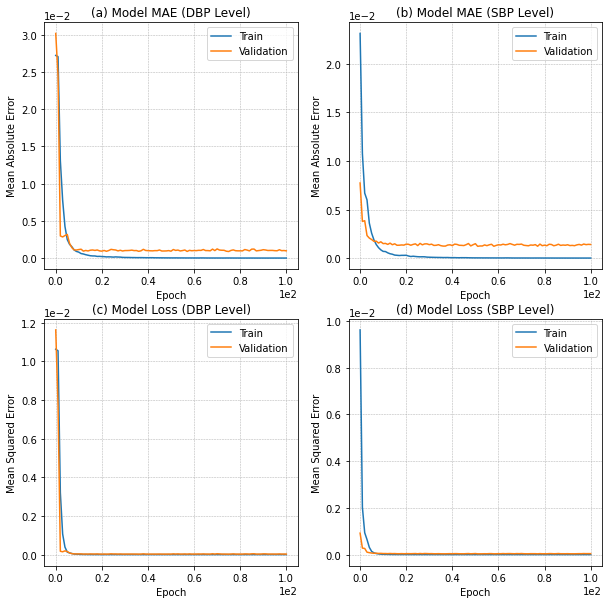

In [21]:
newtrainSBPLoss = [i*1000 for i in trainSBPLoss]
newtrainDBPLoss = [i*1000 for i in trainDBPLoss]
newvalSBPLoss = [i*1000 for i in valSBPLoss]
newvalDBPLoss = [i*1000 for i in valDBPLoss]

newtrainSBPMAE = [i*1000 for i in trainSBPMAE]
newtrainDBPMAE = [i*1000 for i in trainDBPMAE]
newvalSBPMAE = [i*1000 for i in valSBPMAE]
newvalDBPMAE = [i*1000 for i in valDBPMAE]

# plotLosses(newtrainSBPLoss, newtrainDBPLoss, newvalSBPLoss, newvalDBPLoss, newtrainSBPMAE, newtrainDBPMAE, newvalSBPMAE, newvalDBPMAE)
plotLosses(trainSBPLoss, trainDBPLoss, valSBPLoss, valDBPLoss, trainSBPMAE, trainDBPMAE, valSBPMAE, valDBPMAE)

# Testing the model

In [22]:
model = torch.load(bestModelPath)

In [23]:
sbps = []
dbps = []
outputsbps = []
outputdbps = []

with torch.no_grad():
  model.eval()
  for batch_idx, sample in enumerate(test_data_loader):
    feature, sbp, dbp = sample['feature'].to(device), sample['sbp'].to(device), sample['dbp'].to(device)
    output = model(feature)
    sbps.append(sbp.unsqueeze(1))
    dbps.append(dbp.unsqueeze(1))
    outputsbps.append(output['sbp'])
    outputdbps.append(output['dbp'])

In [24]:
sbp = sbps[0]
dbp = dbps[0]
outputsbp = outputsbps[0]
outputdbp = outputdbps[0]

for i in range(1,len(sbps)):
  sbp = torch.cat((sbp, sbps[i]))
  dbp = torch.cat((dbp, dbps[i]))
  outputsbp = torch.cat((outputsbp, outputsbps[i]))
  outputdbp = torch.cat((outputdbp, outputdbps[i]))

In [25]:
# Calculates Mean Absolute % error
def MAPELoss(output, target):
  return torch.mean(torch.abs((target - output)*100.0 / target))

def MAE(output, target):
  return torch.mean(torch.abs(target-output)*180.0)

def stdError(output, target):
  return torch.std((target-output)*180.0)

In [26]:
print("MAPE for SBP: ", MAPELoss(outputsbp, sbp), "MAPE for DBP: ", MAPELoss(outputdbp, dbp))
print("MAE for SBP: ", MAE(outputsbp, sbp), "MAE for DBP: ", MAE(outputdbp, dbp))
print("Standard deviation SBP: ", stdError(outputsbp, sbp), "Standard deviation DBP: ", stdError(outputdbp, dbp))

MAPE for SBP:  tensor(2.7340, device='cuda:0') MAPE for DBP:  tensor(4.3029, device='cuda:0')
MAE for SBP:  tensor(3.0863, device='cuda:0') MAE for DBP:  tensor(2.8969, device='cuda:0')
Standard deviation SBP:  tensor(3.5437, device='cuda:0') Standard deviation DBP:  tensor(3.8044, device='cuda:0')


# Visualizations

## Ground value vs Predicted Value

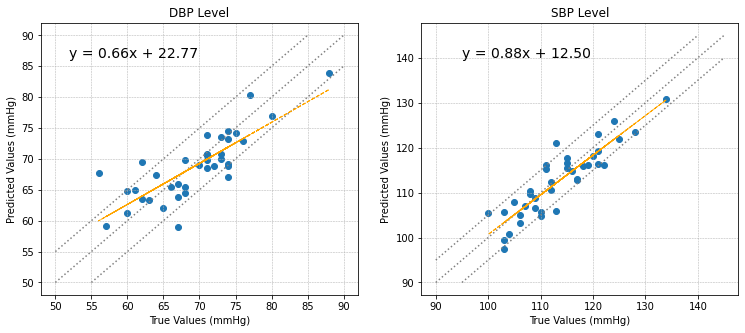

In [27]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize = (12.5,5), tight_layout = False)

ax1.scatter(dbp.to('cpu')*180.0, outputdbp.to('cpu')*180.0)
ax1.plot([50, 90], [50, 90], ls='dotted', color='#808080')
ax1.plot([50, 85], [55, 90], ls='dotted', color='#808080')
ax1.plot([55, 90], [50, 85], ls='dotted', color='#808080')
ax1.grid(linestyle = '--', linewidth = 0.5)
ax1.set_xlabel("True Values (mmHg)")
ax1.set_ylabel("Predicted Values (mmHg)")
ax1.set_title("DBP Level")

x = dbp.to('cpu')*180.0
x = x[:,0]
y = outputdbp.to('cpu')*180.0
y = y[:,0]
a, b = np.polyfit(x, y, 1)
ax1.plot(x, a*x+b, color='orange', linestyle='--', linewidth=1)
plt.text(20, 140, 'y = ' + '{:.2f}'.format(a) + 'x' + ' + {:.2f}'.format(b), size=14)

ax2.scatter(sbp.to('cpu')*180.0, outputsbp.to('cpu')*180.0)
ax2.plot([90, 140], [95, 145], ls='dotted', color='#808080')
ax2.plot([95, 145], [90, 140], ls='dotted', color='#808080')
ax2.plot([90, 145], [90, 145], ls='dotted', color='#808080')
ax2.grid(linestyle = '--', linewidth = 0.5)
ax2.set_xlabel("True Values (mmHg)")
ax2.set_ylabel("Predicted Values (mmHg)")
ax2.set_title("SBP Level")

x = sbp.to('cpu')*180.0
x = x[:,0]
y = outputsbp.to('cpu')*180.0
y = y[:,0]
a, b = np.polyfit(x, y, 1)
ax2.plot(x, a*x+b, color='orange', linestyle='--', linewidth=1)
plt.text(95, 140, 'y = ' + '{:.2f}'.format(a) + 'x' + ' + {:.2f}'.format(b), size=14)

plt.show()

In [28]:
# plt.figure(figsize=(18,8))
# plt.subplot(1,2,1)
# plt.scatter(sbp.to('cpu')*180.0, outputsbp.to('cpu')*180.0)
# plt.xlabel("Ground Values")
# plt.ylabel("Predicted Values")
# plt.title("SBP values")
# plt.grid(linestyle = '--', linewidth = 0.5)
# plt.plot([90, 140], [95, 145], ls='dotted', color='#808080')
# plt.plot([95, 145], [90, 140], ls='dotted', color='#808080')
# plt.plot([90, 145], [90, 145], ls='dotted', color='#808080')
# # plt.text(-5, 60, 'Parabola $Y = x^2$', fontsize = 22)

# #Plot lines of best fit
# x = sbp.to('cpu')*180.0
# x = x[:,0]
# y = outputsbp.to('cpu')*180.0
# y = y[:,0]
# a, b = np.polyfit(x, y, 1)
# plt.plot(x, a*x+b, color='orange', linestyle='--', linewidth=1)

# plt.subplot(1,2,2)
# plt.scatter(dbp.to('cpu')*180.0, outputdbp.to('cpu')*180.0)
# plt.xlabel("Ground Values")
# plt.ylabel("Predicted Values")
# plt.title("DBP values")
# plt.grid(linestyle = '--', linewidth = 0.5)
# plt.plot([50, 90], [50, 90], ls='dotted', color='#808080')
# plt.plot([50, 85], [55, 90], ls='dotted', color='#808080')
# plt.plot([55, 90], [50, 85], ls='dotted', color='#808080')

# #Plot lines of best fit
# x = dbp.to('cpu')*180.0
# x = x[:,0]
# y = outputdbp.to('cpu')*180.0
# y = y[:,0]
# a, b = np.polyfit(x, y, 1)
# plt.plot(x, a*x+b, color='orange', linestyle='--', linewidth=1)

# plt.show()

## Absolute Error (DBP) vs Absolute Error(SBP)

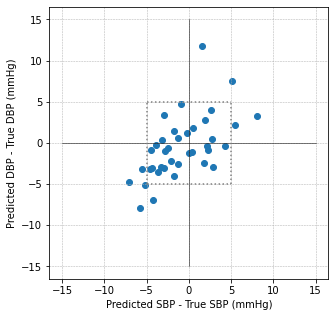

In [29]:
sbpError = outputsbp - sbp
dbpError = outputdbp - dbp

plt.figure(figsize=(5,5))
plt.scatter(sbpError.to('cpu')*180.0, dbpError.to('cpu')*180.0)
plt.xlabel("Predicted SBP - True SBP (mmHg)")
plt.ylabel("Predicted DBP - True DBP (mmHg)")
plt.grid(linestyle = '--', linewidth = 0.5)
plt.plot([0, 0], [-15, 15], linewidth = 0.5, color="#000000")
plt.plot([-15, 15], [0, 0], linewidth = 0.5, color="#000000")
plt.xticks([ -15, -10, -5, 0, 5, 10, 15])
plt.yticks([ -15, -10, -5, 0, 5, 10, 15])

plt.plot([-5, -5], [-5, 5], ls='dotted', color='#808080')
plt.plot([5, 5], [-5, 5], ls='dotted', color='#808080')
plt.plot([-5, 5], [-5, -5], ls='dotted', color='#808080')
plt.plot([-5, 5], [5, 5], ls='dotted', color='#808080')

plt.show()

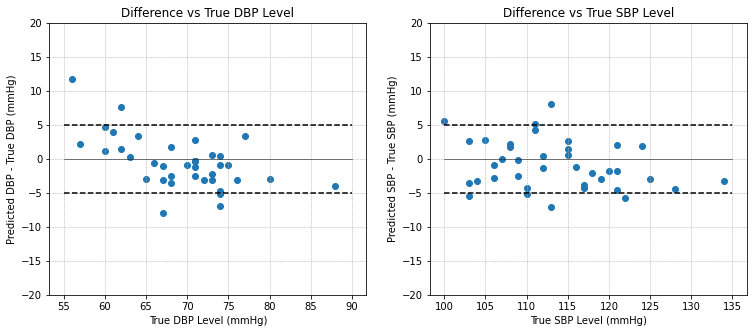

In [30]:
plt.figure(figsize=(12.5,5))
plt.subplot(1,2,1)
plt.scatter(dbp.to('cpu')*180.0, (outputdbp.to('cpu') - dbp.to('cpu'))*180.0)
plt.xlabel("True DBP Level (mmHg)")
plt.ylabel("Predicted DBP - True DBP (mmHg)")
plt.ylim(-20,20)
plt.title("Difference vs True DBP Level")
plt.grid(linestyle = '--', linewidth = 0.5)

plt.plot([55, 90], [5, 5], ls='--', color='#000000')
plt.plot([55, 90], [0, 0], linewidth = 0.5, color="#000000")
plt.plot([55, 90], [-5, -5], ls='--', color='#000000')

plt.subplot(1,2,2)
plt.scatter(sbp.to('cpu')*180.0, (outputsbp.to('cpu') - sbp.to('cpu'))*180.0)
plt.xlabel("True SBP Level (mmHg)")
plt.ylabel("Predicted SBP - True SBP (mmHg)")
plt.title("Difference vs True SBP Level")
plt.ylim(-20,20)
plt.grid(linestyle = '--', linewidth = 0.5)

plt.plot([100, 135], [5, 5], ls='--', color='#000000')
plt.plot([100, 135], [0, 0], linewidth = 0.5, color="#000000")
plt.plot([100, 135], [-5, -5], ls='--', color='#000000')

plt.show()

# Total Trainable parameters

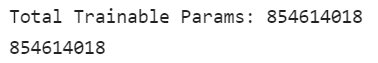